In [1]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# データの読み込み

In [3]:
train_path = "../Datasets/DefectDetect/casting_512x512/casting_512x512/"
test_path = "../Datasets/DefectDetect/casting_data/casting_data/test/"

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((100, 100)),])
train_dataset = datasets.ImageFolder(train_path, transform)
test_dataset  = datasets.ImageFolder(test_path, transform)

In [5]:
batch_size = 64

train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset)-train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
print("Total number of train : ", train_size)
print("Total number of val : ", val_size)
print("Total number of val : ", len(test_dataset))

Total number of train :  1040
Total number of val :  260
Total number of val :  715


# Model development

In [7]:
# class Feactor(nn.Module):
#     def __init__(self, image_size):
#         super(Feactor,self).__init__()
#         self.image_size = image_size
        
#         self.pre_layer = nn.Sequential(
#             nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
#             nn.ReLU()
#         )
#         self.residual_layer = nn.Sequential(
#             ResidualBlock(64),
#             ResidualBlock(64),
# #             ResidualBlock(64),
# #             ResidualBlock(64),
#         )
#         self.last_layer = nn.Sequential(
#             nn.Conv2d(64,16,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(1),
#         )
#         self.dense_layer=nn.Sequential(
# #             nn.AdaptiveAvgPool2d((10)),
#             nn.Flatten(),
#             nn.Linear(1*100*100, 2),
#         )

    
#     def forward(self, input_image):
#         pre = self.pre_layer(input_image)
#         res = self.residual_layer(pre)
#         last = self.last_layer(res)
#         output = self.dense_layer(last)
#         return output
    
    
# class ResidualBlock(nn.Module):
#     def __init__(self, input_channel):
#         super(ResidualBlock,self).__init__()
#         self.residualblock = nn.Sequential(
#             nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(input_channel),
#             nn.ReLU(),
#             nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(input_channel),
#             nn.ReLU(),
#             nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(input_channel),
#         )
#     def forward(self, x):
#         residual = self.residualblock(x)
#         return x + residual

In [15]:
model = models.resnet18(pretrained=True)

model.layer3 = nn.Sequential()
model.layer4 = nn.Sequential()

model.fc = nn.Sequential(
    nn.Linear(128, 2))

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
image_size = 100
# ngpu = 4
# model = Feactor(image_size).to(device)
# if (device.type == 'cuda') and (ngpu > 1):
#     model = nn.DataParallel(model, list(range(ngpu)))
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


In [17]:
# model = torch.load("Feactor.pkl")

# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

In [18]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

In [19]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [20]:
n_epoches = 50
for epoch in range(n_epoches):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.695, Accuracy: 0.660], Valid [Loss: 724.397, Accuracy: 0.573]
EPOCH: 1, Train [Loss: 0.595, Accuracy: 0.721], Valid [Loss: 25.596, Accuracy: 0.573]
EPOCH: 2, Train [Loss: 0.496, Accuracy: 0.757], Valid [Loss: 0.455, Accuracy: 0.773]
EPOCH: 3, Train [Loss: 0.460, Accuracy: 0.780], Valid [Loss: 0.683, Accuracy: 0.585]
EPOCH: 4, Train [Loss: 0.397, Accuracy: 0.797], Valid [Loss: 0.835, Accuracy: 0.496]
EPOCH: 5, Train [Loss: 0.377, Accuracy: 0.816], Valid [Loss: 2.006, Accuracy: 0.692]
EPOCH: 6, Train [Loss: 0.366, Accuracy: 0.827], Valid [Loss: 0.591, Accuracy: 0.769]
EPOCH: 7, Train [Loss: 0.436, Accuracy: 0.795], Valid [Loss: 0.711, Accuracy: 0.527]
EPOCH: 8, Train [Loss: 0.384, Accuracy: 0.808], Valid [Loss: 1.020, Accuracy: 0.469]
EPOCH: 9, Train [Loss: 0.456, Accuracy: 0.788], Valid [Loss: 4.293, Accuracy: 0.592]
EPOCH: 10, Train [Loss: 0.428, Accuracy: 0.800], Valid [Loss: 32.711, Accuracy: 0.573]
EPOCH: 11, Train [Loss: 0.467, Accuracy: 0.786], Valid [Loss

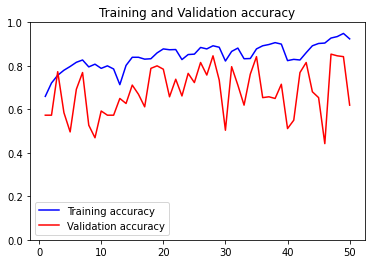

<Figure size 432x288 with 0 Axes>

In [21]:
# train processing plot
n_epoches = n_epoches
epochs=range(1,n_epoches+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# test with testdata

In [22]:
# Test
total = 0
acc_test = 0
y_ture = []
y_pred = []
out_pred = []

model.eval()
for x, y in dataloader_test:
    total += y.size()[0]
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    pred = output.argmax(1)
    acc_test += (pred == y).float().sum().item()
#     for i in range(y.size()[0]):
#         y_pred.append(pred[i])
#         y_ture.append(y[i])
#         out_pred.append(output[i,1])



print('accuracy_score: {:.3f}'.format(acc_test/total))
# y_ture = np.array(y_ture)
# y_pred = np.array(y_pred)
# out_pred = np.array(out_pred)
# print("total_test: {:}" .format(total))
# print('accuracy_score: {:.3f}'.format(accuracy_score(y_ture, y_pred)))
# print('precision_score: {:.3f}'.format(precision_score(y_ture, y_pred)))
# print('roc_auc_score: {:.3f}'.format(roc_auc_score(y_ture, out_pred)))

# fpr, tpr, thresholds = roc_curve(y_true, out_pred,drop_intermediate=True)
# plt.plot(fpr, tpr, marker='.')
# plt.xlabel('FPR: False positive rate')
# plt.ylabel('TPR: True positive rate')
# plt.grid()

accuracy_score: 0.669


# Feature Detection

In [23]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

max: 12.581, min: -275.288


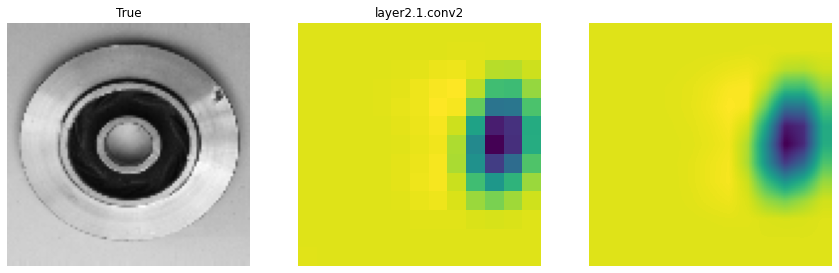

In [73]:
target_layers = ["layer2.1.conv2"]
label = 0

if label == 0:
    img = cv2.imread(train_path+"def_front/cast_def_0_93.jpeg")
else:
    img = cv2.imread(train_path+"ok_front/cast_ok_0_304.jpeg")

img = cv2.resize(img, (100,100))
img = np.float32(img)/255
for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
input_tensor = transform(img).unsqueeze(0).to(device)
output = model(input_tensor)
y = output.argmax(1).cpu().item()

plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.title(y==label)
plt.imshow(img/np.amax(img))
plt.axis("off")

bn = feature_activation[key].cpu()[0].mean(axis=0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(bn),torch.amin(bn)))
#     bn = (bn*(255/torch.amax(bn))).to(torch.int64)
#     print('max: {:}, min: {:}'.format(torch.amax(bn),torch.amin(bn)))
plt.subplot(1,4,2)
plt.title(key)
plt.axis("off")
plt.imshow(bn)

bn = cv2.resize(bn.numpy(), (100,100))
plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(bn)

# plt.subplot(1,4,4)
# plt.axis("off")
# bn = cv2.normalize(bn)
# bn = np.float32(bn)/255
# bn = cv2.merge([bn,bn,bn])
# cam = bn + np.float32(img)
# cam = cam / np.max(cam)
# cam = np.uint8(255 * cam)
# plt.imshow(cam)

In [26]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

conv1  :  torch.Size([1, 64, 50, 50])
bn1  :  torch.Size([1, 64, 50, 50])
relu  :  torch.Size([1, 64, 50, 50])
maxpool  :  torch.Size([1, 64, 25, 25])
layer1.0.conv1  :  torch.Size([1, 64, 25, 25])
layer1.0.bn1  :  torch.Size([1, 64, 25, 25])
layer1.0.relu  :  torch.Size([1, 64, 25, 25])
layer1.0.conv2  :  torch.Size([1, 64, 25, 25])
layer1.0.bn2  :  torch.Size([1, 64, 25, 25])
layer1.0  :  torch.Size([1, 64, 25, 25])
layer1.1.conv1  :  torch.Size([1, 64, 25, 25])
layer1.1.bn1  :  torch.Size([1, 64, 25, 25])
layer1.1.relu  :  torch.Size([1, 64, 25, 25])
layer1.1.conv2  :  torch.Size([1, 64, 25, 25])
layer1.1.bn2  :  torch.Size([1, 64, 25, 25])
layer1.1  :  torch.Size([1, 64, 25, 25])
layer1  :  torch.Size([1, 64, 25, 25])
layer2.0.conv1  :  torch.Size([1, 128, 13, 13])
layer2.0.bn1  :  torch.Size([1, 128, 13, 13])
layer2.0.relu  :  torch.Size([1, 128, 13, 13])
layer2.0.conv2  :  torch.Size([1, 128, 13, 13])
layer2.0.bn2  :  torch.Size([1, 128, 13, 13])
layer2.0.downsample.0  :  torch.S

# GradCAM

In [71]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    if np.amax(gb)!=0:
        gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

True


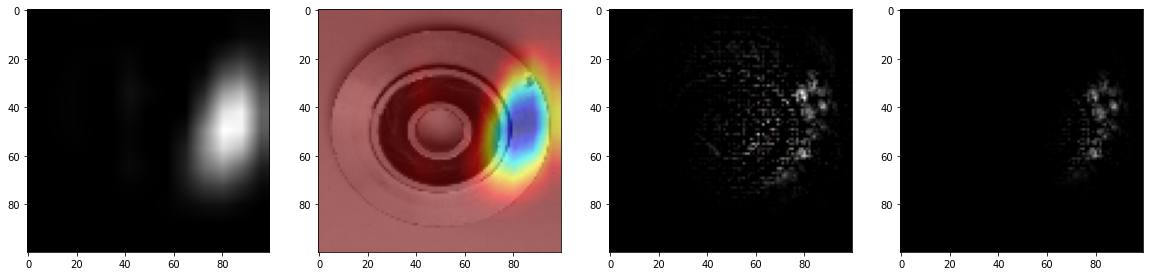

In [82]:
target_layers = [model.layer2[1].conv1]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
print(y==label)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(cam)
plt.subplot(1,4,2)
plt.imshow(visualization)
plt.subplot(1,4,3)
plt.imshow(gb)
plt.subplot(1,4,4)
plt.imshow(cam_gb)

# save model

In [96]:
# for param in model.parameters():
#     param.requires_grad = True
# torch.save(model,"Feactor.pkl")